Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/training-with-deep-learning/train-hyperparameter-tune-deploy-with-keras/train-hyperparameter-tune-deploy-with-keras.png)

# Training, hyperparameter tune, and deploy with Keras

## Introduction
This tutorial shows how to train a simple deep neural network using the MNIST dataset and Keras on Azure Machine Learning. MNIST is a popular dataset consisting of 70,000 grayscale images. Each image is a handwritten digit of `28x28` pixels, representing number from 0 to 9. The goal is to create a multi-class classifier to identify the digit each image represents, and deploy it as a web service in Azure.

For more information about the MNIST dataset, please visit [Yan LeCun's website](http://yann.lecun.com/exdb/mnist/).

## Prerequisite:
* Understand the [architecture and terms](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture) introduced by Azure Machine Learning
* If you are using an Azure Machine Learning Notebook VM, you are all set. Otherwise, go through the [configuration notebook](../../../configuration.ipynb) to:
    * install the AML SDK
    * create a workspace and its configuration file (`config.json`)
* For local scoring test, you will also need to have `tensorflow` and `keras` installed in the current Jupyter kernel.

Let's get started. First let's import some Python libraries.

In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
import azureml
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.79


## Initialize workspace
Initialize a [Workspace](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspace) object from the existing workspace you created in the Prerequisites step. `Workspace.from_config()` creates a workspace object from the details stored in `config.json`.

In [3]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: global-ai-bootcamp
Azure region: westeurope
Subscription id: b2c41e0c-ff7a-45e7-8c40-f53e8ea364af
Resource group: gaib2019


## Create an Azure ML experiment
Let's create an experiment named "keras-mnist" and a folder to hold the training scripts. The script runs will be recorded under the experiment in Azure.

In [4]:
from azureml.core import Experiment

script_folder = './keras-mnist'
os.makedirs(script_folder, exist_ok=True)

exp = Experiment(workspace=ws, name='keras-mnist')

## Explore data

Before you train a model, you need to understand the data that you are using to train it. In this section you learn how to:

* Download the MNIST dataset
* Display some sample images

### Download the MNIST dataset

Download the MNIST dataset and save the files into a `data` directory locally.  Images and labels for both training and testing are downloaded.

In [5]:
import urllib.request

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename=os.path.join(data_folder, 'train-images.gz'))
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename=os.path.join(data_folder, 'train-labels.gz'))
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename=os.path.join(data_folder, 'test-images.gz'))
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename=os.path.join(data_folder, 'test-labels.gz'))

('/Users/mia/Documents/projects/lab-ai/train-hyperparameter-tune-deploy-with-keras/data/test-labels.gz',
 <http.client.HTTPMessage at 0x117471c90>)

### Display some sample images

Load the compressed files into `numpy` arrays. Then use `matplotlib` to plot 30 random images from the dataset with their labels above them. Note this step requires a `load_data` function that's included in an `utils.py` file. This file is included in the sample folder. Please make sure it is placed in the same folder as this notebook. The `load_data` function simply parses the compressed files into numpy arrays.

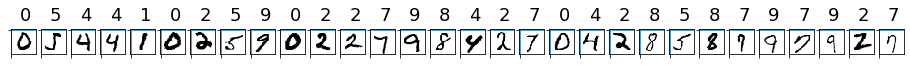

In [6]:
# make sure utils.py is in the same directory as this code
from utils import load_data, one_hot_encode

# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
X_train = load_data(os.path.join(data_folder, 'train-images.gz'), False) / 255.0
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0
y_train = load_data(os.path.join(data_folder, 'train-labels.gz'), True).reshape(-1)
y_test = load_data(os.path.join(data_folder, 'test-labels.gz'), True).reshape(-1)

# now let's show some randomly chosen images from the training set.
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)
plt.show()

Now you have an idea of what these images look like and the expected prediction outcome.

## Create a FileDataset
A FileDataset references one or multiple files in your datastores or public urls. The files can be of any format. FileDataset provides you with the ability to download or mount the files to your compute. By creating a dataset, you create a reference to the data source location. If you applied any subsetting transformations to the dataset, they will be stored in the dataset as well. The data remains in its existing location, so no extra storage cost is incurred. [Learn More](https://aka.ms/azureml/howto/createdatasets)

In [9]:
#!pip3 install azureml.dataprep
from azureml.core.dataset import Dataset

web_paths = [
            'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
            'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
            'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
            'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
            ]
dataset = Dataset.File.from_files(path = web_paths)

Use the `register()` method to register datasets to your workspace so they can be shared with others, reused across various experiments, and referred to by name in your training script.

In [10]:
dataset = dataset.register(workspace = ws,
                           name = 'mnist dataset',
                           description='training and test dataset',
                           create_new_version=True)

## Create or Attach existing AmlCompute
You will need to create a [compute target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) for training your model. In this tutorial, you create `AmlCompute` as your training compute resource.

If we could not find the cluster with the given name, then we will create a new cluster here. We will create an `AmlCompute` cluster of `STANDARD_NC6` GPU VMs. This process is broken down into 3 steps:
1. create the configuration (this step is local and only takes a second)
2. create the cluster (this step will take about **20 seconds**)
3. provision the VMs to bring the cluster to the initial size (of 1 in this case). This step will take about **3-5 minutes** and is providing only sparse output in the process. Please make sure to wait until the call returns before moving to the next cell

In [11]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "gpu-cluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6', 
                                                           max_nodes=4)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it uses the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

# use get_status() to get a detailed status for the current cluster. 
print(compute_target.get_status().serialize())

Creating a new compute target...
Creating
Succeeded
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2019-12-14T13:00:00.593000+00:00', 'errors': None, 'creationTime': '2019-12-14T12:59:57.895328+00:00', 'modifiedTime': '2019-12-14T13:00:13.364600+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_NC6'}


Now that you have created the compute target, let's see what the workspace's `compute_targets` property returns. You should now see one entry named "gpu-cluster" of type `AmlCompute`.

In [12]:
compute_targets = ws.compute_targets
for name, ct in compute_targets.items():
    print(name, ct.type, ct.provisioning_state)

gpu-cluster AmlCompute Succeeded


## Copy the training files into the script folder
The Keras training script is already created for you. You can simply copy it into the script folder, together with the utility library used to load compressed data file into numpy array.

In [13]:
import shutil

# the training logic is in the keras_mnist.py file.
shutil.copy('./keras_mnist.py', script_folder)

# the utils.py just helps loading data from the downloaded MNIST dataset into numpy arrays.
shutil.copy('./utils.py', script_folder)

'./keras-mnist/utils.py'

## Construct neural network in Keras


### Azure ML concepts  
Please note the following three things in the code below:
1. The script accepts arguments using the argparse package. In this case there is one argument `--data_folder` which specifies the FileDataset in which the script can find the MNIST data
```
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_folder')
```
2. The script is accessing the Azure ML `Run` object by executing `run = Run.get_context()`. Further down the script is using the `run` to report the loss and accuracy at the end of each epoch via callback.
```
    run.log('Loss', log['loss'])
    run.log('Accuracy', log['acc'])
```
3. When running the script on Azure ML, you can write files out to a folder `./outputs` that is relative to the root directory. This folder is specially tracked by Azure ML in the sense that any files written to that folder during script execution on the remote target will be picked up by Run History; these files (known as artifacts) will be available as part of the run history record.

The next cell will print out the training code for you to inspect.

In [14]:
with open(os.path.join(script_folder, './keras_mnist.py'), 'r') as f:
    print(f.read())

# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

import numpy as np
import argparse
import os
import glob

import matplotlib.pyplot as plt

import keras
from keras.models import Sequential, model_from_json
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.callbacks import Callback

import tensorflow as tf

from azureml.core import Run
from utils import load_data, one_hot_encode

print("Keras version:", keras.__version__)
print("Tensorflow version:", tf.__version__)

parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--batch-size', type=int, dest='batch_size', default=50, help='mini batch size for training')
parser.add_argument('--first-layer-neurons', type=int, dest='n_hidden_1', default=100,
                    help='# of neurons in the first layer')
parser.add_argument('--second-layer-neurons', type=int, 

## Create TensorFlow estimator & add Keras
Next, we construct an `azureml.train.dnn.TensorFlow` estimator object, use the `gpu-cluster` as compute target, and pass the mount-point of the datastore to the training code as a parameter.
The TensorFlow estimator is providing a simple way of launching a TensorFlow training job on a compute target. It will automatically provide a docker image that has TensorFlow installed. In this case, we add `keras` package (for the Keras framework obviously), and `matplotlib` package for plotting a "Loss vs. Accuracy" chart and record it in run history.

In [15]:
from azureml.core.dataset import Dataset

dataset = Dataset.get_by_name(ws, 'mnist dataset')

# list the files referenced by mnist dataset
dataset.to_path()

/usr/local/lib/python3.7/site-packages/azureml/dataprep/api/dataflow.py:689: UserWarning: Please install pyarrow>=0.11.0 for improved performance of to_pandas_dataframe. You can ensure the correct version is installed by running: pip install azureml-dataprep[pandas].
  warnings.warn('Please install pyarrow>=0.11.0 for improved performance of to_pandas_dataframe. '


array(['/http/yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
       '/http/yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
       '/http/yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
       '/http/yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'],
      dtype=object)

In [16]:
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

# set up environment
env = Environment('my_env')
cd = CondaDependencies.create(pip_packages=['keras','azureml-sdk','tensorflow-gpu','matplotlib','azureml-dataprep[pandas,fuse]>=1.1.14'])

env.python.conda_dependencies = cd

In [18]:
!pip3 install azureml.train
from azureml.train.dnn import TensorFlow

script_params = {
    '--data-folder': dataset.as_named_input('mnist').as_mount(),
    '--batch-size': 50,
    '--first-layer-neurons': 300,
    '--second-layer-neurons': 100,
    '--learning-rate': 0.001
}

est = TensorFlow(source_directory=script_folder,
                 script_params=script_params,
                 compute_target=compute_target, 
                 entry_script='keras_mnist.py', 
                 environment_definition= env)

     |████████████████████████████████| 8.6MB 1.6MB/s eta 0:00:01
     |████████████████████████████████| 61kB 2.8MB/s eta 0:00:011


WARNING - If environment_definition or conda_dependencies_file_path is specified, Azure ML will not install any framework related packages on behalf of the user.
WARNING - This compute target type doesn't support non-Docker runs; overriding run configuration enable Docker.
WARNING - framework_version is not specified, defaulting to version 1.13.


## Submit job to run
Submit the estimator to the Azure ML experiment to kick off the execution.

In [19]:
run = exp.submit(est)

### Monitor the Run
As the Run is executed, it will go through the following stages:
1. Preparing: A docker image is created matching the Python environment specified by the TensorFlow estimator and it will be uploaded to the workspace's Azure Container Registry. This step will only happen once for each Python environment -- the container will then be cached for subsequent runs. Creating and uploading the image takes about **5 minutes**. While the job is preparing, logs are streamed to the run history and can be viewed to monitor the progress of the image creation.

2. Scaling: If the compute needs to be scaled up (i.e. the AmlCompute cluster requires more nodes to execute the run than currently available), the cluster will attempt to scale up in order to make the required amount of nodes available. Scaling typically takes about **5 minutes**.

3. Running: All scripts in the script folder are uploaded to the compute target, data stores are mounted/copied and the `entry_script` is executed. While the job is running, stdout and the `./logs` folder are streamed to the run history and can be viewed to monitor the progress of the run.

4. Post-Processing: The `./outputs` folder of the run is copied over to the run history

There are multiple ways to check the progress of a running job. We can use a Jupyter notebook widget. 

**Note: The widget will automatically update ever 10-15 seconds, always showing you the most up-to-date information about the run**

In [22]:
#!pip3 install azureml.widgets
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'NOTSET',…

We can also periodically check the status of the run object, and navigate to Azure portal to monitor the run.

In [23]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
keras-mnist,keras-mnist_1576328950_393d81f1,azureml.scriptrun,Preparing,Link to Azure Machine Learning studio,Link to Documentation


In [24]:
run.wait_for_completion(show_output=True)

RunId: keras-mnist_1576328950_393d81f1
Web View: https://ml.azure.com/experiments/keras-mnist/runs/keras-mnist_1576328950_393d81f1?wsid=/subscriptions/b2c41e0c-ff7a-45e7-8c40-f53e8ea364af/resourcegroups/gaib2019/workspaces/global-ai-bootcamp

Streaming azureml-logs/20_image_build_log.txt

2019/12/14 13:09:22 Downloading source code...
2019/12/14 13:09:26 Finished downloading source code
2019/12/14 13:09:27 Creating Docker network: acb_default_network, driver: 'bridge'
2019/12/14 13:09:28 Successfully set up Docker network: acb_default_network
2019/12/14 13:09:28 Setting up Docker configuration...
2019/12/14 13:09:31 Successfully set up Docker configuration
2019/12/14 13:09:31 Logging in to registry: globalaiboot34145442.azurecr.io
2019/12/14 13:09:34 Successfully logged into globalaiboot34145442.azurecr.io
2019/12/14 13:09:34 Executing step ID: acb_step_0. Timeout(sec): 5400, Working directory: '', Network: 'acb_default_network'
2019/12/14 13:09:34 Scanning for dependencies...
2019/12/

  Created wheel for pyyaml: filename=PyYAML-5.2-cp36-cp36m-linux_x86_64.whl size=44209 sha256=6c89de35e9e76f0d6206f7e929a9d6bb0018f3fc85c520c54f1cc5e946e59a3f
  Stored in directory: /root/.cache/pip/wheels/54/b7/c7/2ada654ee54483c9329871665aaf4a6056c3ce36f29cf66e67
  Created wheel for opt-einsum: filename=opt_einsum-3.1.0-cp36-none-any.whl size=61682 sha256=dd7f33d21e35d0998c1a062fb6cabf660ebeb2d6de1ac8a6738ab7d227e93d09
  Stored in directory: /root/.cache/pip/wheels/2c/b1/94/43d03e130b929aae7ba3f8d15cbd7bc0d1cb5bb38a5c721833
  Created wheel for termcolor: filename=termcolor-1.1.0-cp36-none-any.whl size=4832 sha256=7e0e176eea3a592399b8d66d47ae61e7df427d047be4bbfbc925b94de3782efb
  Stored in directory: /root/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=cb6ce9d430695dee99f5761de41a442146dbde1a3c83d100376c1e4378f9ac6c
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d

  Created wheel for wrapt: filename=wrapt-1.11.2-cp36-cp36m-linux_x86_64.whl size=66313 sha256=37b309ecfd0ab1dc82875cbb93f4fadd41f689fa013fed1a5c3f8ca657948d39
  Stored in directory: /root/.cache/pip/wheels/d7/de/2e/efa132238792efb6459a96e85916ef8597fcb3d2ae51590dfd
  Created wheel for absl-py: filename=absl_py-0.8.1-cp36-none-any.whl size=121167 sha256=2e05d01d3e55298493b0b81658f128cf3c84050c15a18211085e715dbab50af5
  Stored in directory: /root/.cache/pip/wheels/a7/15/a0/0a0561549ad11cdc1bc8fa1191a353efd30facf6bfb507aefc
  Created wheel for fusepy: filename=fusepy-3.0.1-cp36-none-any.whl size=10505 sha256=ad7240abe0bc1b7fe4cd955803ae03d38d8019c8280a96ab45c334e7f131cf88
  Stored in directory: /root/.cache/pip/wheels/4c/a5/91/7772af9e21c461f07bb40f26d928d7d231d224977dd8353bab
  Created wheel for pathspec: filename=pathspec-0.6.0-cp36-none-any.whl size=26671 sha256=f512d013dcc1af7cf13a5499d158c4966f3c7ea6a6b81b807b23bde846b8ca13
  Stored in directory: /root/.cache/pip/wheels/62/b8/e1/e27

2019/12/14 13:15:56 Successfully populated digests for step ID: acb_step_0
2019/12/14 13:15:56 Step ID: acb_step_1 marked as successful (elapsed time in seconds: 153.129765)
2019/12/14 13:15:56 The following dependencies were found:
2019/12/14 13:15:56 
- image:
    registry: globalaiboot34145442.azurecr.io
    repository: azureml/azureml_be81fc539c037b15bf9f8ed8380534f8
    tag: latest
    digest: sha256:425a537cacba95b0ce9274a16163452e9ca5a62cacf20ceac05c999c9e728c65
  runtime-dependency:
    registry: mcr.microsoft.com
    repository: azureml/base
    tag: intelmpi2018.3-ubuntu16.04
    digest: sha256:a1b514f3ba884b9a7695cbba5638933ddaf222e8ce3e8c81e8cdf861679abb05
  git: {}

Run ID: cb1 was successful after 6m36s

Streaming azureml-logs/55_azureml-execution-tvmps_41bd384810195061994c1d8aa18b438e63a190721a193cd674bc6d1b797f5152_d.txt

2019-12-14T13:21:26Z Starting output-watcher...
Login Succeeded
Using default tag: latest
latest: Pulling from azureml/azureml_be81fc539c037b15bf9f8ed

 - 3s - loss: 0.2134 - accuracy: 0.9362 - val_loss: 0.1156 - val_accuracy: 0.9639
Epoch 2/20
 - 3s - loss: 0.0909 - accuracy: 0.9726 - val_loss: 0.0861 - val_accuracy: 0.9736
Epoch 3/20
 - 3s - loss: 0.0655 - accuracy: 0.9810 - val_loss: 0.0835 - val_accuracy: 0.9763
Epoch 4/20
 - 3s - loss: 0.0495 - accuracy: 0.9852 - val_loss: 0.0967 - val_accuracy: 0.9723
Epoch 5/20
 - 3s - loss: 0.0398 - accuracy: 0.9882 - val_loss: 0.1017 - val_accuracy: 0.9756
Epoch 6/20
 - 3s - loss: 0.0332 - accuracy: 0.9901 - val_loss: 0.1007 - val_accuracy: 0.9766
Epoch 7/20
 - 3s - loss: 0.0273 - accuracy: 0.9917 - val_loss: 0.0917 - val_accuracy: 0.9796
Epoch 8/20
 - 3s - loss: 0.0228 - accuracy: 0.9934 - val_loss: 0.0925 - val_accuracy: 0.9802
Epoch 9/20
 - 3s - loss: 0.0183 - accuracy: 0.9949 - val_loss: 0.1076 - val_accuracy: 0.9820
Epoch 10/20
 - 3s - loss: 0.0173 - accuracy: 0.9955 - val_loss: 0.1391 - val_accuracy: 0.9766
Epoch 11/20
 - 3s - loss: 0.0141 - accuracy: 0.9959 - val_loss: 0.1055 - val_acc

{'runId': 'keras-mnist_1576328950_393d81f1',
 'target': 'gpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2019-12-14T13:21:23.427733Z',
 'endTimeUtc': '2019-12-14T13:24:33.701046Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '010541c9-586e-45eb-8411-e3d0faff21cc',
  'azureml.git.repository_uri': 'https://github.com/pymia/lab-ai',
  'mlflow.source.git.repoURL': 'https://github.com/pymia/lab-ai',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': 'e27abfabc16e09441d8c49907f9303f3eecb0a0f',
  'mlflow.source.git.commit': 'e27abfabc16e09441d8c49907f9303f3eecb0a0f',
  'azureml.git.dirty': 'False',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': 'a921bad9-aa80-41fd-b72e-dd394c5f9e07'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'mnist', 'mechanism': 'Mount'}}],
 'runDefinition': {'scr

In the outputs of the training script, it prints out the Keras version number. Please make a note of it.

### The Run object
The Run object provides the interface to the run history -- both to the job and to the control plane (this notebook), and both while the job is running and after it has completed. It provides a number of interesting features for instance:
* `run.get_details()`: Provides a rich set of properties of the run
* `run.get_metrics()`: Provides a dictionary with all the metrics that were reported for the Run
* `run.get_file_names()`: List all the files that were uploaded to the run history for this Run. This will include the `outputs` and `logs` folder, azureml-logs and other logs, as well as files that were explicitly uploaded to the run using `run.upload_file()`

Below are some examples -- please run through them and inspect their output. 

In [25]:
run.get_details()

{'runId': 'keras-mnist_1576328950_393d81f1',
 'target': 'gpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2019-12-14T13:21:23.427733Z',
 'endTimeUtc': '2019-12-14T13:24:33.701046Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '010541c9-586e-45eb-8411-e3d0faff21cc',
  'azureml.git.repository_uri': 'https://github.com/pymia/lab-ai',
  'mlflow.source.git.repoURL': 'https://github.com/pymia/lab-ai',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': 'e27abfabc16e09441d8c49907f9303f3eecb0a0f',
  'mlflow.source.git.commit': 'e27abfabc16e09441d8c49907f9303f3eecb0a0f',
  'azureml.git.dirty': 'False',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': 'a921bad9-aa80-41fd-b72e-dd394c5f9e07'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'mnist', 'mechanism': 'Mount'}}],
 'runDefinition': {'scr

In [26]:
run.get_metrics()

{'Loss': [0.2134210901160259,
  0.09090594724208738,
  0.06545100705804846,
  0.04946763539599488,
  0.039794143977220905,
  0.033217808092263115,
  0.027277469098000134,
  0.022775867339736352,
  0.018273127093845574,
  0.01729857324342651,
  0.014122294248109644,
  0.012743587401775893,
  0.012011960680613906,
  0.010209363648292055,
  0.007782116871156552,
  0.007195530821808177,
  0.007489188692860458,
  0.006712169249973422,
  0.006472164775310115,
  0.005953782579804631],
 'Accuracy': [0.9362499713897705,
  0.9726333618164062,
  0.9809666872024536,
  0.9852166771888733,
  0.9882166385650635,
  0.9901333451271057,
  0.9917333126068115,
  0.9934499859809875,
  0.9949166774749756,
  0.9954666495323181,
  0.9959333539009094,
  0.9964666962623596,
  0.9968666434288025,
  0.9971500039100647,
  0.9978833198547363,
  0.9980666637420654,
  0.9980166554450989,
  0.9981333613395691,
  0.9982333183288574,
  0.9981833100318909],
 'Final test loss': 0.16261538544835524,
 'Final test accuracy':

In [27]:
run.get_file_names()

['Accuracy vs Loss_1576329844.png',
 'azureml-logs/20_image_build_log.txt',
 'azureml-logs/55_azureml-execution-tvmps_41bd384810195061994c1d8aa18b438e63a190721a193cd674bc6d1b797f5152_d.txt',
 'azureml-logs/65_job_prep-tvmps_41bd384810195061994c1d8aa18b438e63a190721a193cd674bc6d1b797f5152_d.txt',
 'azureml-logs/70_driver_log.txt',
 'azureml-logs/75_job_post-tvmps_41bd384810195061994c1d8aa18b438e63a190721a193cd674bc6d1b797f5152_d.txt',
 'azureml-logs/process_info.json',
 'azureml-logs/process_status.json',
 'logs/azureml/153_azureml.log',
 'logs/azureml/azureml.log',
 'outputs/model/model.h5',
 'outputs/model/model.json']

## Download the saved model

In the training script, the Keras model is saved into two files, `model.json` and `model.h5`, in the `outputs/models` folder on the gpu-cluster AmlCompute node. Azure ML automatically uploaded anything written in the `./outputs` folder into run history file store. Subsequently, we can use the `run` object to download the model files. They are under the the `outputs/model` folder in the run history file store, and are downloaded into a local folder named `model`.

In [23]:
# create a model folder in the current directory
os.makedirs('./model', exist_ok=True)

for f in run.get_file_names():
    if f.startswith('outputs/model'):
        output_file_path = os.path.join('./model', f.split('/')[-1])
        print('Downloading from {} to {} ...'.format(f, output_file_path))
        run.download_file(name=f, output_file_path=output_file_path)

WARNING - Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ProtocolError('Connection aborted.', OSError("(60, 'ETIMEDOUT')"))': /azureml/ExperimentRun/dcid.keras-mnist_1576280333_c01ee9b1/outputs/model/model.h5?sv=2019-02-02&sr=b&sig=7vb%2FEAI%2FXfAbv%2B8AYZT6c4xFMXfxJMH8mtrwPSBjhzA%3D&st=2019-12-13T23%3A36%3A01Z&se=2019-12-14T07%3A46%3A01Z&sp=r


## Predict on the test set
Let's check the version of the local Keras. Make sure it matches with the version number printed out in the training script. Otherwise you might not be able to load the model properly.

In [24]:
import keras 
import tensorflow as tf

print("Keras version:", keras.__version__)
print("Tensorflow version:", tf.__version__)

Using TensorFlow backend.


Keras version: 2.3.1
Tensorflow version: 1.15.0


Now let's load the downloaded model.

In [25]:
from keras.models import model_from_json

# load json and create model
json_file = open('model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model/model.h5")
print("Model loaded from disk.")

WARNING - From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model loaded from disk.


Feed test dataset to the persisted model to get predictions.

In [26]:
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
y_test_ohe = one_hot_encode(y_test, 10)
y_hat = np.argmax(loaded_model.predict(X_test), axis=1)

# print the first 30 labels and predictions
print('labels:  \t', y_test[:30])
print('predictions:\t', y_hat[:30])

WARNING - From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



labels:  	 [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]
predictions:	 [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1]


Calculate the overall accuracy by comparing the predicted value against the test set.

In [27]:
print("Accuracy on the test set:", np.average(y_hat == y_test))

Accuracy on the test set: 0.9796


## Intelligent hyperparameter tuning
We have trained the model with one set of hyperparameters, now let's how we can do hyperparameter tuning by launching multiple runs on the cluster. First let's define the parameter space using random sampling.

In [28]:
from azureml.train.hyperdrive import RandomParameterSampling, BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice, loguniform

ps = RandomParameterSampling(
    {
        '--batch-size': choice(25, 50, 100),
        '--first-layer-neurons': choice(10, 50, 200, 300, 500),
        '--second-layer-neurons': choice(10, 50, 200, 500),
        '--learning-rate': loguniform(-6, -1)
    }
)

Next, we will create a new estimator without the above parameters since they will be passed in later by Hyperdrive configuration. Note we still need to keep the `data-folder` parameter since that's not a hyperparamter we will sweep.

In [29]:
est = TensorFlow(source_directory=script_folder,
                 script_params={'--data-folder': dataset.as_named_input('mnist').as_mount()},
                 compute_target=compute_target,
                 entry_script='keras_mnist.py', 
                 environment_definition= env)

WARNING - If environment_definition or conda_dependencies_file_path is specified, Azure ML will not install any framework related packages on behalf of the user.
WARNING - framework_version is not specified, defaulting to version 1.13.


Now we will define an early termnination policy. The `BanditPolicy` basically states to check the job every 2 iterations. If the primary metric (defined later) falls outside of the top 10% range, Azure ML terminate the job. This saves us from continuing to explore hyperparameters that don't show promise of helping reach our target metric.

In [30]:
policy = BanditPolicy(evaluation_interval=2, slack_factor=0.1)

Now we are ready to configure a run configuration object, and specify the primary metric `Accuracy` that's recorded in your training runs. If you go back to visit the training script, you will notice that this value is being logged after every epoch (a full batch set). We also want to tell the service that we are looking to maximizing this value. We also set the number of samples to 20, and maximal concurrent job to 4, which is the same as the number of nodes in our computer cluster.

In [31]:
hdc = HyperDriveConfig(estimator=est, 
                       hyperparameter_sampling=ps, 
                       policy=policy, 
                       primary_metric_name='Accuracy', 
                       primary_metric_goal=PrimaryMetricGoal.MAXIMIZE, 
                       max_total_runs=20,
                       max_concurrent_runs=4)

Finally, let's launch the hyperparameter tuning job.

In [32]:
hdr = exp.submit(config=hdc)

We can use a run history widget to show the progress. Be patient as this might take a while to complete.

In [33]:
RunDetails(hdr).show()

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO'…

In [34]:
hdr.wait_for_completion(show_output=True)

RunId: keras-mnist_1576280869967295
Web View: https://mlworkspace.azure.ai/portal/subscriptions/b2c41e0c-ff7a-45e7-8c40-f53e8ea364af/resourceGroups/book-ai/providers/Microsoft.MachineLearningServices/workspaces/mlworkspace/experiments/keras-mnist/runs/keras-mnist_1576280869967295

Streaming azureml-logs/hyperdrive.txt

"<START>[2019-12-13T23:47:50.476290][API][INFO]Experiment created<END>\n""<START>[2019-12-13T23:47:50.984877][GENERATOR][INFO]Trying to sample '4' jobs from the hyperparameter space<END>\n""<START>[2019-12-13T23:47:51.209305][GENERATOR][INFO]Successfully sampled '4' jobs, they will soon be submitted to the execution target.<END>\n"<START>[2019-12-13T23:47:51.4813639Z][SCHEDULER][INFO]The execution environment is being prepared. Please be patient as it can take a few minutes.<END>

Execution Summary
RunId: keras-mnist_1576280869967295
Web View: https://mlworkspace.azure.ai/portal/subscriptions/b2c41e0c-ff7a-45e7-8c40-f53e8ea364af/resourceGroups/book-ai/providers/Microsoft

{'runId': 'keras-mnist_1576280869967295',
 'target': 'gpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2019-12-13T23:47:50.331028Z',
 'endTimeUtc': '2019-12-14T00:08:11.986154Z',
 'properties': {'primary_metric_config': '{"name": "Accuracy", "goal": "maximize"}',
  'resume_from': 'null',
  'runTemplate': 'HyperDrive',
  'azureml.runsource': 'hyperdrive',
  'platform': 'AML',
  'baggage': 'eyJvaWQiOiAiN2I4YmYwNDYtODUyYS00NTVlLWFjNmEtZWNkNjEwMTg5NjczIiwgInRpZCI6ICJjOGY4NjU0YS05NTZlLTRjZGUtYmE4OS1jYzI5YTExZjY4ZTQiLCAidW5hbWUiOiAiMDRiMDc3OTUtOGRkYi00NjFhLWJiZWUtMDJmOWUxYmY3YjQ2In0',
  'ContentSnapshotId': '8d9210eb-588b-4815-ae63-0c0c4c372d43',
  'score': '0.9932833313941956',
  'best_child_run_id': 'keras-mnist_1576280869967295_16',
  'best_metric_status': 'Succeeded'},
 'inputDatasets': [],
 'logFiles': {'azureml-logs/hyperdrive.txt': 'https://mlworkspace6465733497.blob.core.windows.net/azureml/ExperimentRun/dcid.keras-mnist_1576280869967295/azureml-logs/hyperdrive.txt?sv=2019-02-

## Find and register best model
When all the jobs finish, we can find out the one that has the highest accuracy.

In [35]:
best_run = hdr.get_best_run_by_primary_metric()
print(best_run.get_details()['runDefinition']['arguments'])

['--data-folder', 'DatasetConsumptionConfig:mnist', '--batch-size', '50', '--first-layer-neurons', '300', '--learning-rate', '0.00569802085063863', '--second-layer-neurons', '10']


Now let's list the model files uploaded during the run.

In [36]:
print(best_run.get_file_names())

['Accuracy vs Loss_1576281878.png', 'azureml-logs/55_azureml-execution-tvmps_6391237ac8593e9d7b3dabff3227e28b7e6ec87c1d88d8e5a280a4b09b8be35a_d.txt', 'azureml-logs/65_job_prep-tvmps_6391237ac8593e9d7b3dabff3227e28b7e6ec87c1d88d8e5a280a4b09b8be35a_d.txt', 'azureml-logs/70_driver_log.txt', 'azureml-logs/75_job_post-tvmps_6391237ac8593e9d7b3dabff3227e28b7e6ec87c1d88d8e5a280a4b09b8be35a_d.txt', 'azureml-logs/process_info.json', 'azureml-logs/process_status.json', 'logs/azureml/152_azureml.log', 'logs/azureml/azureml.log', 'outputs/model/model.h5', 'outputs/model/model.json']


We can then register the folder (and all files in it) as a model named `keras-dnn-mnist` under the workspace for deployment.

In [37]:
model = best_run.register_model(model_name='keras-mlp-mnist', model_path='outputs/model')

## Deploy the model in ACI
Now we are ready to deploy the model as a web service running in Azure Container Instance [ACI](https://azure.microsoft.com/en-us/services/container-instances/). Azure Machine Learning accomplishes this by constructing a Docker image with the scoring logic and model baked in.
### Create score.py
First, we will create a scoring script that will be invoked by the web service call. 

* Note that the scoring script must have two required functions, `init()` and `run(input_data)`. 
  * In `init()` function, you typically load the model into a global object. This function is executed only once when the Docker container is started. 
  * In `run(input_data)` function, the model is used to predict a value based on the input data. The input and output to `run` typically use JSON as serialization and de-serialization format but you are not limited to that.

In [38]:
%%writefile score.py
import json
import numpy as np
import os
from keras.models import model_from_json

from azureml.core.model import Model

def init():
    global model
    
    model_root = Model.get_model_path('keras-mlp-mnist')
    # load json and create model
    json_file = open(os.path.join(model_root, 'model.json'), 'r')
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)
    # load weights into new model
    model.load_weights(os.path.join(model_root, "model.h5"))   
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_hat = np.argmax(model.predict(data), axis=1)
    return y_hat.tolist()

Writing score.py


### Create myenv.yml
We also need to create an environment file so that Azure Machine Learning can install the necessary packages in the Docker image which are required by your scoring script. In this case, we need to specify conda packages `tensorflow` and `keras`.

In [39]:
from azureml.core.runconfig import CondaDependencies

cd = CondaDependencies.create()
cd.add_conda_package('tensorflow')
cd.add_conda_package('keras')
cd.save_to_file(base_directory='./', conda_file_path='myenv.yml')

print(cd.serialize_to_string())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - azureml-defaults==1.0.69.*
- tensorflow
- keras
channels:
- conda-forge



### Deploy to ACI
We are almost ready to deploy. Create the inference configuration and deployment configuration and deploy to ACI. This cell will run for about 7-8 minutes.

In [40]:
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.webservice import Webservice
from azureml.core.model import Model

inference_config = InferenceConfig(runtime= "python", 
                                   entry_script="score.py",
                                   conda_file="myenv.yml")

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1,
                                               auth_enabled=True, # this flag generates API keys to secure access
                                               memory_gb=1,
                                               tags={'name': 'mnist', 'framework': 'Keras'},
                                               description='Keras MLP on MNIST')

service = Model.deploy(workspace=ws, 
                           name='keras-mnist-svc', 
                           models=[model], 
                           inference_config=inference_config, 
                           deployment_config=aciconfig)

service.wait_for_deployment(True)
print(service.state)

Running.....................................................................................................
SucceededACI service creation operation finished, operation "Succeeded"
Healthy


**Tip: If something goes wrong with the deployment, the first thing to look at is the logs from the service by running the following command:** `print(service.get_logs())`

This is the scoring web service endpoint:

In [41]:
print(service.scoring_uri)

http://f67f14dc-5400-4e0e-9bf6-a41d3a618b49.westeurope.azurecontainer.io/score


### Test the deployed model
Let's test the deployed model. Pick 30 random samples from the test set, and send it to the web service hosted in ACI. Note here we are using the `run` API in the SDK to invoke the service. You can also make raw HTTP calls using any HTTP tool such as curl.

After the invocation, we print the returned predictions and plot them along with the input images. Use red font color and inversed image (white on black) to highlight the misclassified samples. Note since the model accuracy is pretty high, you might have to run the below cell a few times before you can see a misclassified sample.

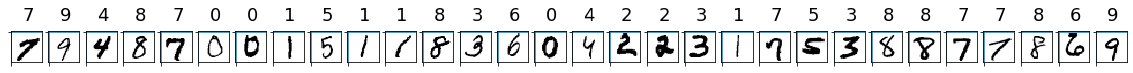

In [42]:
import json

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize = (20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y=-10, s=y_test[s], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)
    
    i = i + 1
plt.show()

We can retreive the API keys used for accessing the HTTP endpoint.

In [43]:
# retreive the API keys. two keys were generated.
key1, Key2 = service.get_keys()
print(key1)

QJJr3Dd8aaxOgQYs5RTmFso8pH3xasaj


We can now send construct raw HTTP request and send to the service. Don't forget to add key to the HTTP header.

In [44]:
import requests

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type':'application/json', 'Authorization': 'Bearer ' + key1}

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
#print("input data:", input_data)
print("label:", y_test[random_index])
print("prediction:", resp.text)

POST to url http://f67f14dc-5400-4e0e-9bf6-a41d3a618b49.westeurope.azurecontainer.io/score
label: 9
prediction: [9]


Let's look at the workspace after the web service was deployed. You should see 
* a registered model named 'keras-mlp-mnist' and with the id 'model:1'  
* a webservice called 'keras-mnist-svc' with some scoring URL

In [45]:
models = ws.models
for name, model in models.items():
    print("Model: {}, ID: {}".format(name, model.id))
    
webservices = ws.webservices
for name, webservice in webservices.items():
    print("Webservice: {}, scoring URI: {}".format(name, webservice.scoring_uri))

Model: keras-mlp-mnist, ID: keras-mlp-mnist:1
Webservice: keras-mnist-svc, scoring URI: http://f67f14dc-5400-4e0e-9bf6-a41d3a618b49.westeurope.azurecontainer.io/score


## Clean up
You can delete the ACI deployment with a simple delete API call.

In [ ]:
service.delete()